# Import Packages

In [1]:
pip install pytorch-ignite

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 922.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━

In [2]:
import pandas as pd
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage.io import imread
import numpy as np
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
import pickle
import seaborn as sns
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score
import torchvision
import torchvision.models as models
from torch.utils.data.sampler import SubsetRandomSampler
import os
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,sampler, random_split
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from ignite.engine import Engine, Events, create_supervised_trainer, create_supervised_evaluator
from ignite.handlers import ModelCheckpoint, EarlyStopping
from ignite.metrics import Accuracy, Loss, RunningAverage, ConfusionMatrix
Categories=['trash','recycle','organics', 'hazardous']

# Load the data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [24]:
train_dir="/content/drive/MyDrive/APS360/APS360data/train"
val_dir="/content/drive/MyDrive/APS360/APS360data/val"
test_dir="/content/drive/MyDrive/APS360/APS360data/test2"

In [25]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

torch.manual_seed(1)
# Define transformations and normalization for your images:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images for the VGG model
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Standard normalization for ImageNet
])

# Load datasets:
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

# Set up data loaders:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  #Shuffle is to ensure the model isn’t adapting its learning to any kind of spurious pattern.
validation_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Our Best Performance DenseNet Model (With Pretrained Parameters)

In [6]:
model = models.densenet201(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth
100%|██████████| 77.4M/77.4M [00:01<00:00, 61.5MB/s]


In [7]:
#Freezing the model
for param in model.parameters():
  param.requires_grad = False

In [8]:
#Change the last layer to have a output shape of 4
n_inputs = model.classifier.in_features
last_layer = nn.Linear(n_inputs, 4)
model.classifier = last_layer
print(model.classifier.out_features)

4


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [10]:
def train(model, train_loader, val_loader, batch_size=32,
              lr=0.001, num_epochs=15):
    criterion = nn.CrossEntropyLoss()
    # For multi-class classification
    optimizer = optim.Adam(model.parameters(), lr=0.001)  # Use Adam optimizer with a learning rate of 0.01

    n = 0
    iters, losses, train_acc_list,val_acc_list = [],[],[],[]
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        train_preds = []
        train_targets = []

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(torch.device("cuda:0" if torch.cuda.is_available() else "cpu")), labels.to(torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            train_preds.extend(predicted.cpu().numpy())
            train_targets.extend(labels.cpu().numpy())

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = accuracy_score(train_targets, train_preds)
        train_acc_list.append(epoch_acc)
        epoch_f1 = f1_score(train_targets, train_preds, average='weighted')


        model.eval()  # Set model to evaluate mode
        val_running_loss = 0.0
        val_preds = []
        val_targets = []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(torch.device("cuda:0" if torch.cuda.is_available() else "cpu")), labels.to(torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_preds.extend(predicted.cpu().numpy())
                val_targets.extend(labels.cpu().numpy())

        val_loss = val_running_loss / len(val_loader.dataset)
        val_acc = accuracy_score(val_targets, val_preds)
        val_acc_list.append(val_acc)
        val_f1 = f1_score(val_targets, val_preds, average='weighted')

        n += 1
        iters.append(n)
        losses.append(float(val_loss)/batch_size)

        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Training Accuracy: {epoch_acc:.4f}, F1-Score: {epoch_f1:.4f}, Loss: {epoch_loss:.4f}')
        print(f'Validation Accuracy: {val_acc:.4f}, F1-Score: {val_f1:.4f}, Loss: {val_loss:.4f}, ')
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Accuracy Curve")
    plt.plot(iters, train_acc_list, label="Training")
    plt.plot(iters, val_acc_list, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

Epoch 1/15
Training Accuracy: 0.5667, F1-Score: 0.5684, Loss: 1.0974
Validation Accuracy: 0.8350, F1-Score: 0.8357, Loss: 0.7249, 
Epoch 2/15
Training Accuracy: 0.8950, F1-Score: 0.8946, Loss: 0.5681
Validation Accuracy: 0.9150, F1-Score: 0.9153, Loss: 0.4673, 
Epoch 3/15
Training Accuracy: 0.9200, F1-Score: 0.9197, Loss: 0.3933
Validation Accuracy: 0.9000, F1-Score: 0.8975, Loss: 0.3868, 
Epoch 4/15
Training Accuracy: 0.9350, F1-Score: 0.9351, Loss: 0.3418
Validation Accuracy: 0.9600, F1-Score: 0.9602, Loss: 0.3145, 
Epoch 5/15
Training Accuracy: 0.9450, F1-Score: 0.9450, Loss: 0.2628
Validation Accuracy: 0.9600, F1-Score: 0.9602, Loss: 0.2802, 
Epoch 6/15
Training Accuracy: 0.9550, F1-Score: 0.9551, Loss: 0.2353
Validation Accuracy: 0.9600, F1-Score: 0.9602, Loss: 0.2557, 
Epoch 7/15
Training Accuracy: 0.9700, F1-Score: 0.9699, Loss: 0.2034
Validation Accuracy: 0.9600, F1-Score: 0.9599, Loss: 0.2401, 
Epoch 8/15
Training Accuracy: 0.9650, F1-Score: 0.9650, Loss: 0.1808
Validation Acc

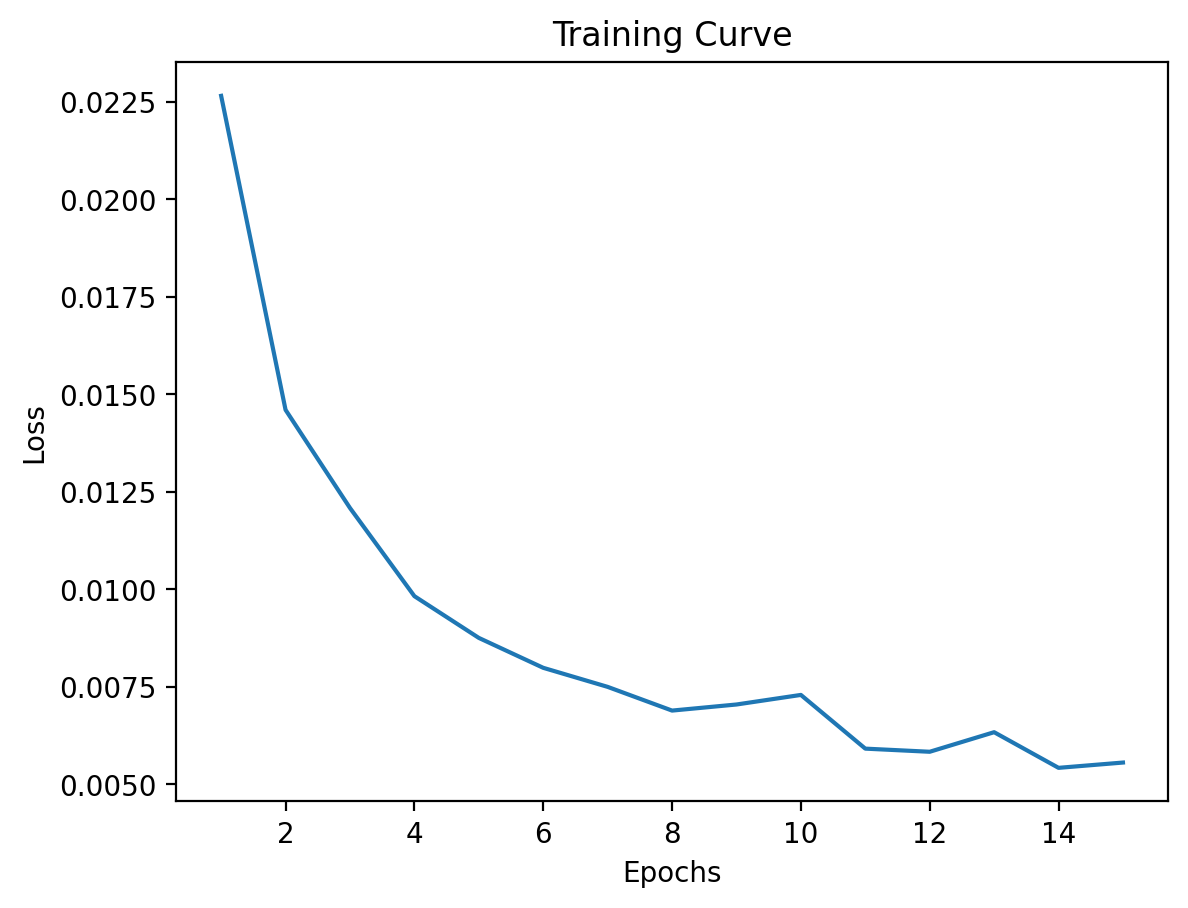

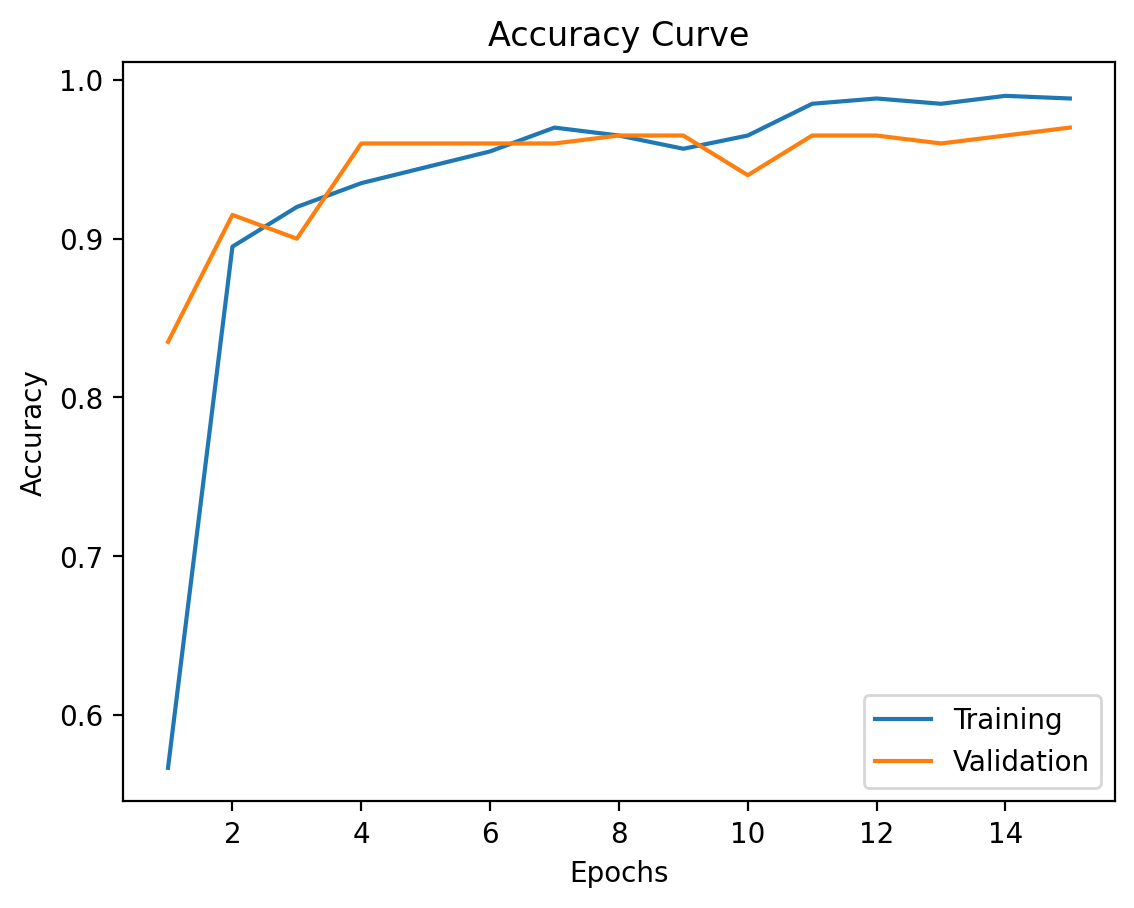

In [11]:
train(model, train_loader, validation_loader, batch_size=32,
              lr=0.001, num_epochs=15)

In [26]:
y_true = []
y_pred = []
# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Then can move  model to the chosen device
model.to(device)
model.eval()  # Set the model to evaluation mode

with torch.no_grad():  # Turn off gradients for test, saves memory and computations
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)

        # Convert outputs probabilities to predicted class (0 or 1) using argmax
        _, preds = torch.max(outputs, 1)

        # Move the results back to CPU and convert them to numpy arrays if not already
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

In [27]:
def confusion_matrix_creation(y_test, y_pred_test, col_names, modelName, color):

    from sklearn.metrics import confusion_matrix
    import matplotlib.pyplot as pl
    import numpy as np

    # Forming confusion matrix
    CM = confusion_matrix(y_test, y_pred_test)
    pl.figure(figsize=(12,8))
    sns.heatmap(CM, annot=True, annot_kws={'size':15}, fmt=".0f", cmap=color, linewidths=5)

    # labels in plot
    tick_marks = np.arange(len(col_names))
    pl.xticks(tick_marks + 0.5, col_names)
    pl.yticks(tick_marks + 0.5, col_names, rotation=0)
    pl.xlabel('Predicted label')
    pl.ylabel('True label')
    pl.title(f'Confusion Matrix of {modelName}')
    pl.show()

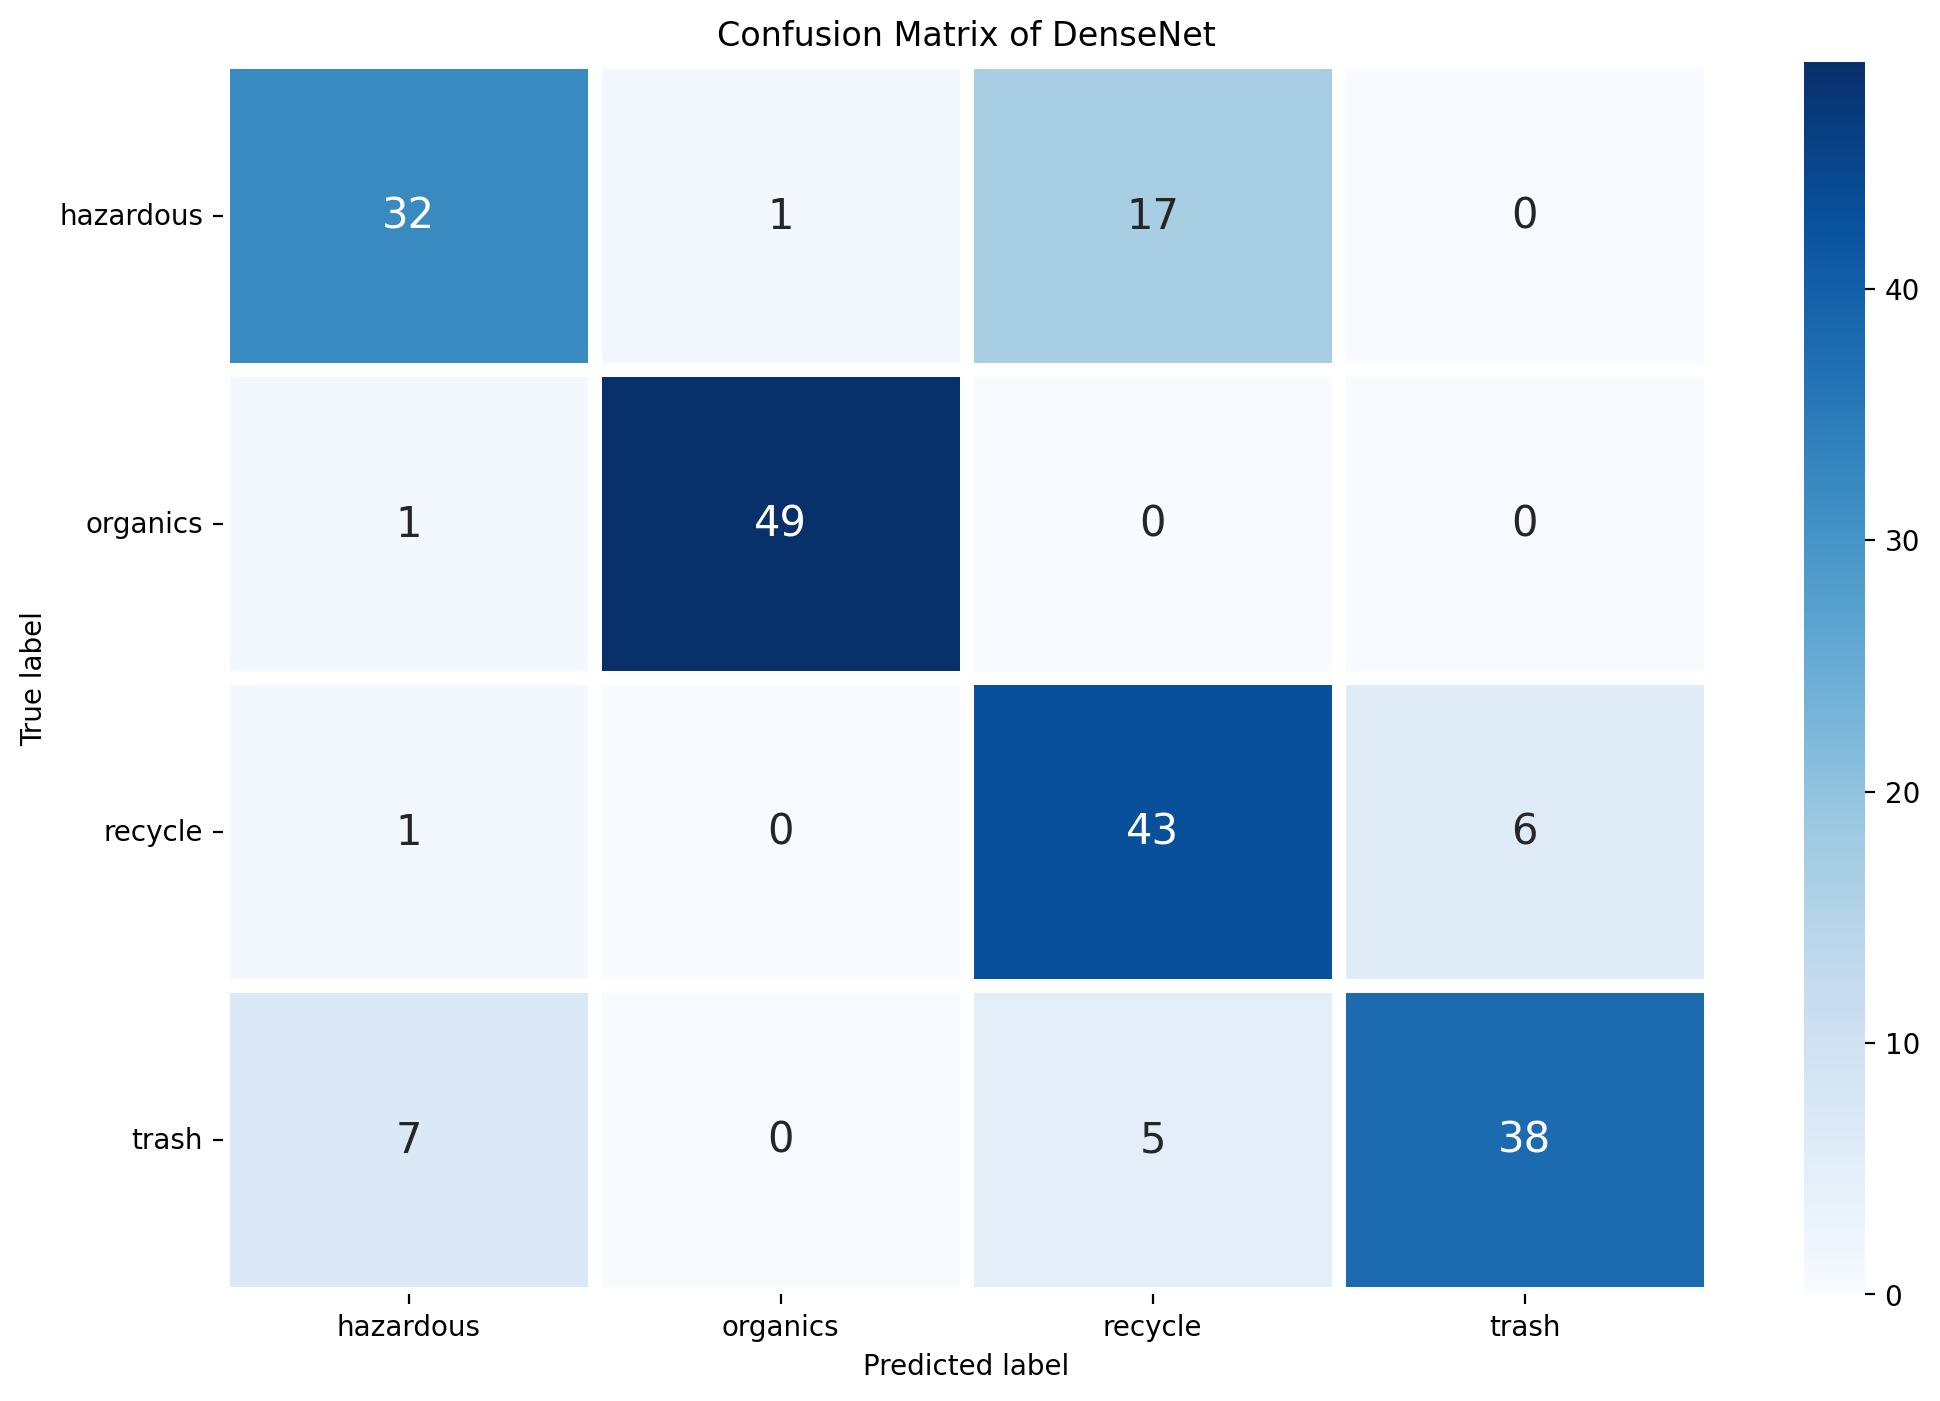

In [32]:
confusion_matrix_creation(y_true, y_pred,['hazardous', 'organics', 'recycle', 'trash'], "DenseNet", "Blues")

In [33]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming `y_true` and `y_pred` are your true and predicted labels:
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f'DenseNet on test set has a accuracy of: {accuracy}')
print(f'DenseNet on test set has a weighted precision of: {precision}')
print(f'DenseNet on test set has a weighted recall of: {recall}')
print(f'DenseNet on test set has a weighted F1-score of:  {f1}')

DenseNet on test set has a accuracy of: 0.81
DenseNet on test set has a weighted precision of: 0.8214156575132185
DenseNet on test set has a weighted recall of: 0.81
DenseNet on test set has a weighted F1-score of:  0.8099083571377744


In [30]:
torch.save(model.state_dict(), "/content/model")